In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# -----------------------
# Data Preprocessing
# -----------------------

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self,df, sequence_length=30):

        signal = df['deliver'].values

        # Prepare sequences and targets
        X, y = [], []
        for i in range(len(signal) - sequence_length):
            X.append(signal[i:i+sequence_length])
            y.append([signal[i+sequence_length]])

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = self.X[idx]
        target = self.y[idx]
        return (torch.tensor(seq, dtype=torch.float32).unsqueeze(-1),
                torch.tensor(target, dtype=torch.float32).unsqueeze(-1))

# -----------------------
# Model Definition
# -----------------------

# Positional Encoding module adds information about the position in the sequence.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=256):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # pe = torch.zeros(max_len, d_model)
        # position = torch.arange(0, max_len).unsqueeze(1)
        # div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        # pe[:, 0::2] = torch.sin(position.float() * div_term)
        # pe[:, 1::2] = torch.cos(position.float() * div_term)
        # pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]
        # self.register_buffer('pe', pe)
        self.pe = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, x):
        # x shape: [batch, seq_len, d_model]
        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return self.dropout(x)

class TransformerTimeSeries2(nn.Module):
    def __init__(self, feature_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(1, feature_size)
        self.pos_encoder = PositionalEncoding(feature_size, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=feature_size, nhead=4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        # self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.input_linear.weight.data.uniform_(-initrange, initrange)
        self.input_linear.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, x):

        x = self.input_linear(x)  # Linear transformation
        # embeeded x shape: (batch_size, sequence_legth, d_model)

        x = self.pos_encoder(x.transpose(0, 1)).transpose(0, 1)  # Add positional encoding
        # print(f"Positional encoded shape: {x.shape}")
        # position embedded x shape: (batch_size, sequence_legth, d_model)

        x = x.transpose(0, 1)
        # Transformer expects (sequence_length, batch_size, d_model)

        # Pass through transformer encoder
        x = self.transformer_encoder(x)
        # after transformer encode shape: (sequence_length, batch_size, d_model)
        # print(f"Transformer output shape: {x.shape}")

        # Take the last time step and predict a. Simplicity b. Computational efficiency
        # Many time series tasks only require the next point prediction,Last step often captures the most recent and relevant information
        x = x[-1]  # Last sequence element
        # last sequence element shape (batch_size, d_model)

        return self.decoder(x)

# -----------------------
# Training Loop
# -----------------------

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            # print('here', X, y)
            optimizer.zero_grad()
            # Forward pass
            predictions = model(X)
            loss = criterion(predictions, y.squeeze(-1))
            # print('there', loss)
            # Backward pass
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # Average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return loss_history

# -----------------------
# Load Data
# -----------------------

normalized_data = pd.read_csv('hour_deliver.csv')
train_ratio = 0.8
batch_size = 32
train_size = int(len(normalized_data) * train_ratio)
train_data = normalized_data[:train_size]
test_data = normalized_data[train_size:]

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

# DataLoaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# -----------------------
# Train Model
# -----------------------

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeries2().to(device)

# Calculate the total number of trainable parameters for the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
loss_history = train_model(model, train_loader, criterion, optimizer)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Total Trainable Parameters: 578881
Epoch [1/50], Loss: 51.4435
Epoch [11/50], Loss: 2.8375
Epoch [21/50], Loss: 2.1739
Epoch [31/50], Loss: 1.7101
Epoch [41/50], Loss: 1.5451


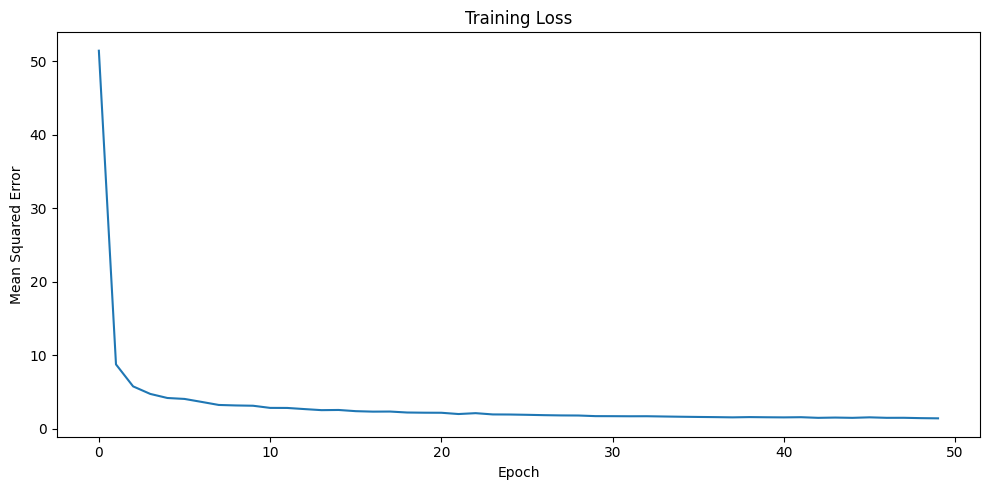

In [3]:

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()


In [6]:
for p in model.parameters():
   if p.requires_grad:
      print(p.numel(), p.shape, type(p))
print(f"Total Trainable Parameters: {total_params}")

64 torch.Size([64, 1]) <class 'torch.nn.parameter.Parameter'>
64 torch.Size([64]) <class 'torch.nn.parameter.Parameter'>
16384 torch.Size([256, 64]) <class 'torch.nn.parameter.Parameter'>
12288 torch.Size([192, 64]) <class 'torch.nn.parameter.Parameter'>
192 torch.Size([192]) <class 'torch.nn.parameter.Parameter'>
4096 torch.Size([64, 64]) <class 'torch.nn.parameter.Parameter'>
64 torch.Size([64]) <class 'torch.nn.parameter.Parameter'>
131072 torch.Size([2048, 64]) <class 'torch.nn.parameter.Parameter'>
2048 torch.Size([2048]) <class 'torch.nn.parameter.Parameter'>
131072 torch.Size([64, 2048]) <class 'torch.nn.parameter.Parameter'>
64 torch.Size([64]) <class 'torch.nn.parameter.Parameter'>
64 torch.Size([64]) <class 'torch.nn.parameter.Parameter'>
64 torch.Size([64]) <class 'torch.nn.parameter.Parameter'>
64 torch.Size([64]) <class 'torch.nn.parameter.Parameter'>
64 torch.Size([64]) <class 'torch.nn.parameter.Parameter'>
12288 torch.Size([192, 64]) <class 'torch.nn.parameter.Parameter

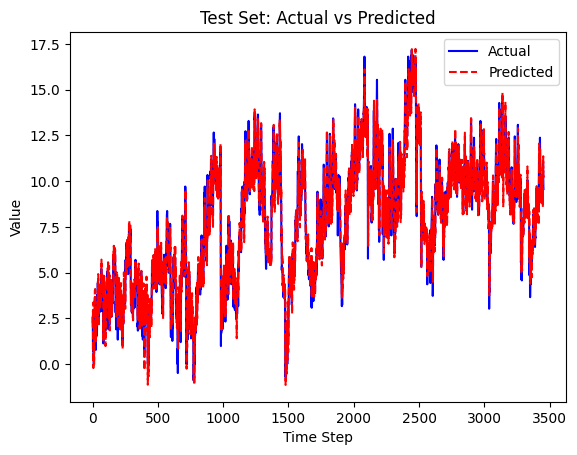

In [4]:
predictions = []
actuals = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)#.squeeze()

        predictions.extend(pred.cpu().numpy())
        actuals.extend(y.squeeze(-1).cpu().numpy())
# Inverse transform to original scale
predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

plt.plot(actuals, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()


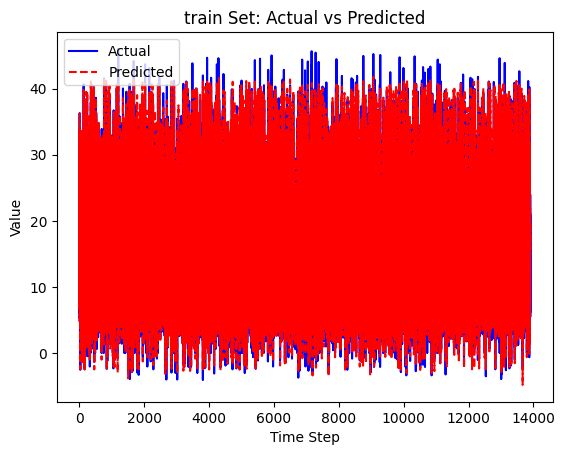

In [5]:
predictions = []
actuals = []

with torch.no_grad():
    for X, y in train_loader:
        pred = model(X).squeeze()
        predictions.extend(pred.numpy())
        actuals.extend(y.numpy())

# Inverse transform to original scale
predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

plt.plot(actuals, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.title('train Set: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
